# PA005: High Value Customer Identification(Insiders)

# <font color = 'red'> 0.0. Imports </font>

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import re
import sqlite3

from matplotlib import pyplot as plt
from matplotlib import cm
from plotly import express as px

from sklearn import cluster as c
from sklearn import metrics as me
from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold as mn
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from sklearn import ensemble as en
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc

from sqlalchemy import create_engine

## 0.2. Load dataset

In [2]:
# load data
path = 'c:\\Users\\pgdem\\repos\\insiders\\'
df_raw = pd.read_csv(path + 'data/raw/data.csv', encoding = 'ISO-8859-1')

# <font color = 'red'> 1.0. Descrição dos Dados </font>

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 
            'quantity', 'invoice_date', 'unit_price', 
            'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [5]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of columns: {}'.format(df1.shape[1]))

number of rows: 541909
number of columns: 8


## 1.3. Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original df with reference df
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce -> combine_firts()
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%m/%d/%Y %H:%M').dt.date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributes

#### Invoice No

In [15]:
# invoices com letras e números -> isso é um problema!
# identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoices.head()

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [16]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# <font color = 'red'> 2.0. Filtragem de Variáveis </font>

In [17]:
df2 = df1.copy()

In [18]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [19]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis = 1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color = 'red'> 3.0. Feature Engineering </font>

In [20]:
df3 = df2.copy()

## 3.1. Feature Creation

In [21]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

### 3.1.1. Gross Revenue

In [22]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases = df2_purchases.copy()
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Days from Last Purchase

In [23]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left' )
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5. Qty of Products Purchased

In [24]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id' ).count()
                                                        .reset_index()
                                                        .rename(columns={'stock_code': 'qty_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
dtype: int64

### 3.1.8. Frequency Purchases

In [25]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby( 'customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'), 
                                                                min_ = ('invoice_date', 'min'),
                                                                days_= ('invoice_date', lambda x: ((x.max() - x.min()).days ) + 1),
                                                                buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
frequency        91
dtype: int64

### 3.1.9. Number of Returns

In [26]:
# returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on = 'customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
frequency        91
qty_returns       0
dtype: int64

# <font color = 'red'> 4.0. EDA (Exploratory Data Analysis) </font>

In [27]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qty_products     0
frequency        0
qty_returns      0
dtype: int64

## 4.3. Estudo de Espaços

In [28]:
# df43 = df4.drop(columns = ['customer_id'], axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 
                'qty_products', 'frequency', 'qty_returns']
df43 = df4[cols_selected].drop(columns='customer_id', axis=1)

In [29]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['qty_products'] = mm.fit_transform(df43[['qty_products']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qty_returns'] = mm.fit_transform(df43[['qty_returns']])

X = df43.copy()

In [30]:
X.shape

(5695, 5)

### 4.3.1. PCA - Principal Component Analysis

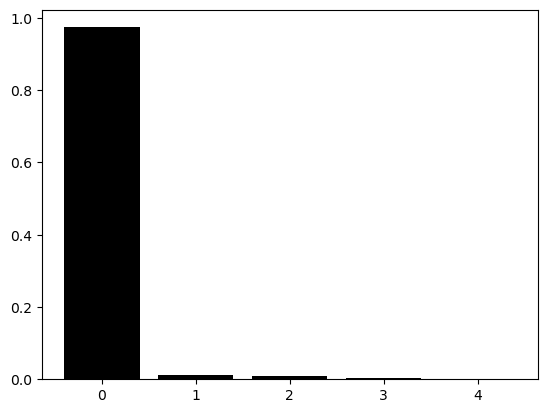

In [31]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot: xlabel='0', ylabel='1'>

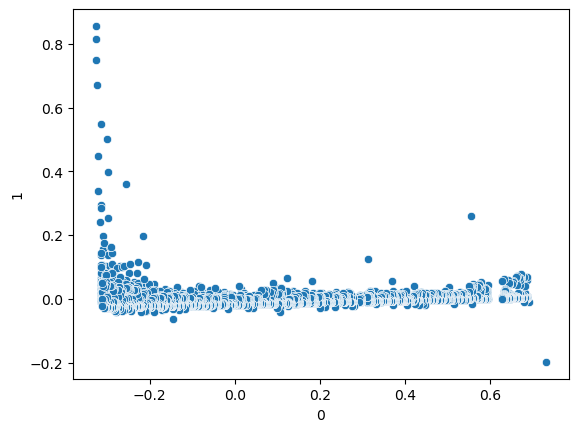

In [32]:
sns.scatterplot(x = 0, y = 1, data = df_pca)

### 4.3.2. UMAP - Uniform Manifold Approximation and Projection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

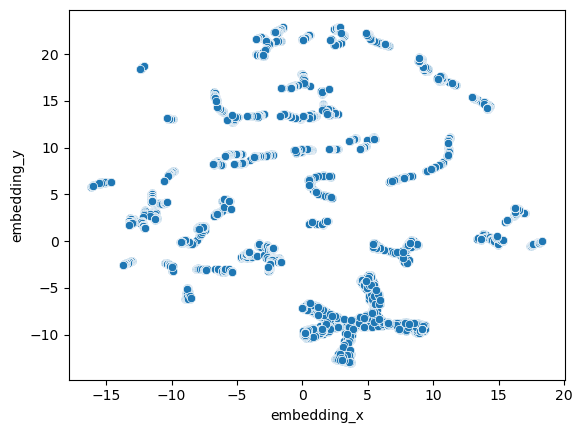

In [33]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y='embedding_y', data=df_umap)

### 4.3.3. t-SNE - t-Distributed Stochastic Neighbor Embedding

c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

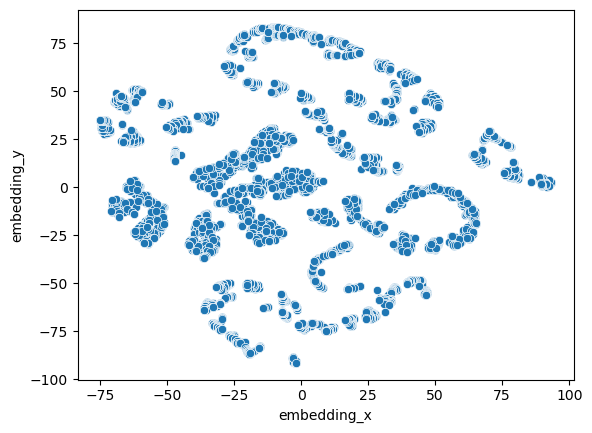

In [34]:
reducer = TSNE(n_components = 2, n_jobs = -1, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tsne)

### 4.3.4. Tree-Based Embedding

In [35]:
# training dataset
X = df4.drop(columns = ['gross_revenue'], axis = 1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf_model.fit(X, y)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

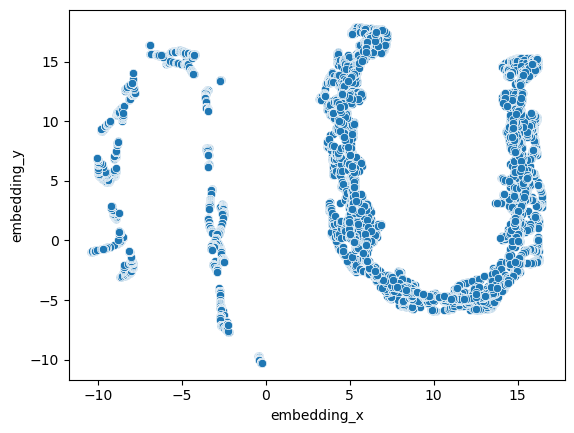

In [36]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y='embedding_y', data=df_tree)

# <font color = 'red'> 5.0. Data Preparation </font>

In [37]:
# tree-based embedding
df5 = df_tree.copy()
df5.to_csv(path + 'src/data/tree_based_embedding.csv', index=False)

In [38]:
# umap embedding
# df5 = df_umap.copy()

In [39]:
# tsne embedding
# df5 = df_tsne.copy()

# <font color = 'red'> 7.0. Hyperparameter Fine-Tunning </font>

In [40]:
X = df5.copy()

In [41]:
X.head()

,embedding_x,embedding_y
0,14.070668,14.635426
1,5.187612,13.056733
2,6.849805,16.317059
3,4.730585,6.742873
4,7.449363,-4.914609


In [42]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1. K-Means

In [43]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters = k, n_init=100, random_state=42)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = me.silhouette_score(X, labels, metric = 'euclidean')
    kmeans_list.append(sil)

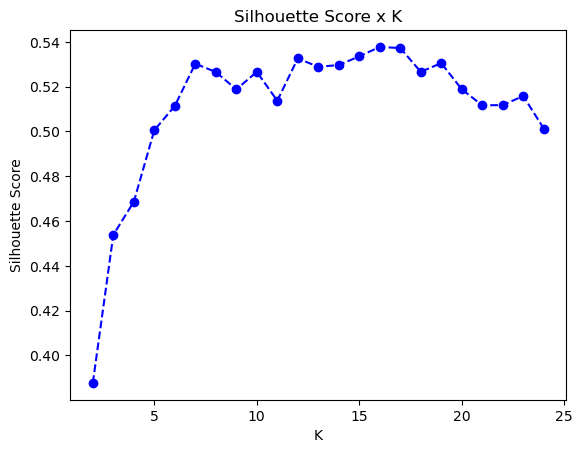

In [44]:
plt.plot(clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.2. GMM

In [45]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k, n_init=100, random_state=42)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = me.silhouette_score(X, labels, metric = 'euclidean')
    gmm_list.append(sil)

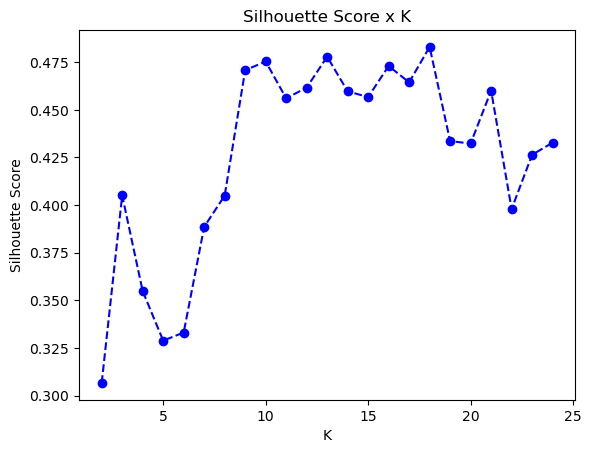

In [46]:
plt.plot(clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.3. Hierarchical Clustering

In [47]:
hc_model = hc.linkage(X, 'ward')

In [48]:
# hc.dendrogram(hc_model, leaf_rotation = 90, leaf_font_size = 8)
# plt.plot()

In [49]:
# hc.dendrogram(hc_model, truncate_mode = 'lastp', p = 12, leaf_rotation = 90, leaf_font_size = 8, show_contracted = True)
# plt.show()

### 7.3.1. HClustering Silhouette Score

In [50]:
hc_list = []

for k in clusters:
    # model definition & training with Scipy
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # metrics
    sil = me.silhouette_score(X, labels, metric = 'euclidean')
    hc_list.append(sil)

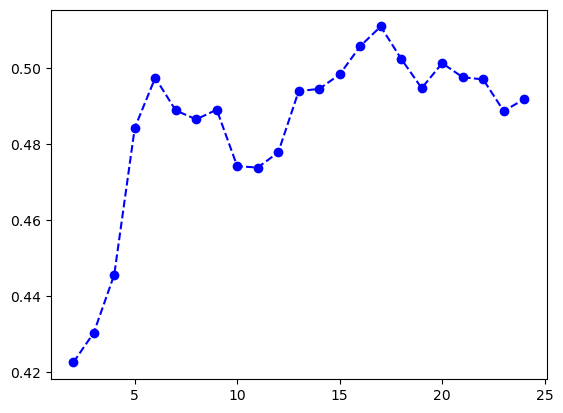

In [51]:
plt.plot(clusters, hc_list, linestyle = '--', marker = 'o', color = 'b')

In [52]:
# 7.5. Results - Tree Based Embedding
df_results = pd.DataFrame({'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list,
                        #'DBSCAN': dbscan_list
                        }
                        ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'green', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.387753,0.453856,0.468610,0.500552,0.511406,0.530250,0.526556,0.518787,0.526617,0.513733,0.532604,0.528870,0.529666,0.533536,0.537747,0.537241,0.526639,0.530501,0.518839,0.511701,0.511750,0.515854,0.501311
GMM,0.306605,0.405025,0.354802,0.328793,0.333070,0.388544,0.404955,0.470770,0.475396,0.456032,0.461665,0.477879,0.459712,0.456693,0.473018,0.464409,0.483027,0.433566,0.432320,0.460047,0.397915,0.426378,0.432772
HC,0.422610,0.430398,0.445671,0.484217,0.497375,0.488780,0.486458,0.488987,0.474130,0.473807,0.477768,0.493881,0.494447,0.498256,0.505658,0.510839,0.502331,0.494652,0.501205,0.497512,0.496937,0.488632,0.491736


In [53]:
# 7.6. Results - UMAP Embedding
df_results = pd.DataFrame({'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list,
                        #'DBSCAN': dbscan_list
                        }
                        ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'green', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.387753,0.453856,0.468610,0.500552,0.511406,0.530250,0.526556,0.518787,0.526617,0.513733,0.532604,0.528870,0.529666,0.533536,0.537747,0.537241,0.526639,0.530501,0.518839,0.511701,0.511750,0.515854,0.501311
GMM,0.306605,0.405025,0.354802,0.328793,0.333070,0.388544,0.404955,0.470770,0.475396,0.456032,0.461665,0.477879,0.459712,0.456693,0.473018,0.464409,0.483027,0.433566,0.432320,0.460047,0.397915,0.426378,0.432772
HC,0.422610,0.430398,0.445671,0.484217,0.497375,0.488780,0.486458,0.488987,0.474130,0.473807,0.477768,0.493881,0.494447,0.498256,0.505658,0.510839,0.502331,0.494652,0.501205,0.497512,0.496937,0.488632,0.491736


In [54]:
# 7.7. Results - t-SNE Embedding
df_results = pd.DataFrame({'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list,
                        #'DBSCAN': dbscan_list
                        }
                        ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'green', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.387753,0.453856,0.468610,0.500552,0.511406,0.530250,0.526556,0.518787,0.526617,0.513733,0.532604,0.528870,0.529666,0.533536,0.537747,0.537241,0.526639,0.530501,0.518839,0.511701,0.511750,0.515854,0.501311
GMM,0.306605,0.405025,0.354802,0.328793,0.333070,0.388544,0.404955,0.470770,0.475396,0.456032,0.461665,0.477879,0.459712,0.456693,0.473018,0.464409,0.483027,0.433566,0.432320,0.460047,0.397915,0.426378,0.432772
HC,0.422610,0.430398,0.445671,0.484217,0.497375,0.488780,0.486458,0.488987,0.474130,0.473807,0.477768,0.493881,0.494447,0.498256,0.505658,0.510839,0.502331,0.494652,0.501205,0.497512,0.496937,0.488632,0.491736


# <font color = 'red'> 8.0. Model Training </font>

## 8.1. Final Model

In [55]:
# model definition
k = 8

# model definition
gmm_model = mx.GaussianMixture(n_components = k, n_init = 300, random_state = 32)

# model training
gmm_model.fit(X)

# model predict
labels = gmm_model.predict(X)

## 8.2. Cluster Validation

In [56]:
# # WSS (Within-Cluster Sum of Square)
# print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(me.silhouette_score(X, labels, metric = 'euclidean')))

SS value: 0.4068644046783447


# <font color = 'red'> 9.0. Cluster Analysis </font>

In [57]:
# df9 = df6.copy()
df9 = X.copy()

In [58]:
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,14.070668,14.635426,3
1,5.187612,13.056733,1
2,6.849805,16.317059,1
3,4.730585,6.742873,4
4,7.449363,-4.914609,0


## 9.1. Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

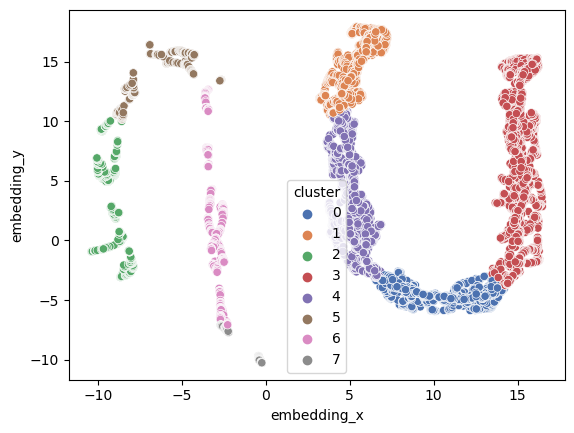

In [59]:
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', hue = 'cluster', data = df9, palette = 'deep')

## 9.2. Cluster Profile

In [60]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,1
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [61]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qty_products = df92[['qty_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qty_returns = df92[['qty_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,qty_returns
7,7,79,1.387182,2744.609747,12.721519,288.835443,1.000000,0.000000
4,4,1137,19.964881,2253.427177,87.544415,113.666667,0.356692,21.671944
1,1,777,13.643547,2039.049794,93.907336,82.048906,0.406304,19.294723
3,3,1682,29.534680,1978.291986,91.668847,84.083234,0.418886,76.863258
0,0,733,12.870939,1530.209168,98.870396,84.253752,0.443426,12.491132
6,6,501,8.797191,1200.145768,98.868263,87.289421,1.000000,0.000000
2,2,453,7.954346,979.631545,319.527594,91.724062,1.000000,0.000000
5,5,333,5.847234,742.249940,214.582583,69.468468,1.000000,0.000000


In [62]:
# 4 Cluster Insiders
# 0 Cluster More Products
# 6 Cluster Spend Money 
# 2 Cluster Even More Products
# 7 Cluster Less Days
# 3 Cluster Less 1k
# 1 Cluster Stop Returners
# 5 Cluster More Buy

### Cluster Cadidato a Insider

- Número de customers: 292 (9% do customers )
- Faturamento médio: 15086
- Recência média: 22 dias
- Média de Produtos comprados: 436 produtos
- Frequência de Produtos comprados: 0.08 produtos/dia
- Receita em média: US$15086.34 dólares

# <font color = 'red'> 10.0. Análise Exploratória de Dados </font>

In [71]:
df10 = df92.copy()

# <font color = 'red'> 11.0. Deploy to Production </font>

In [72]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qty_products       int64
frequency        float64
qty_returns        int64
cluster            int64
dtype: object

In [73]:
df92['recency_days'] = df92['recency_days'].astype('int64')
df92['qty_products'] = df92['qty_products'].astype('int64')
df92['qty_returns'] = df92['qty_returns'].astype('int64')

In [74]:
host = 'sqlite:///insiders_db.sqlite'
conn = create_engine(host)

In [75]:
host = 'sqlite:///insiders_db.sqlite'
conn = create_engine(host)

# drop table
query_drop_insiders = """
    DROP TABLE insiders
"""

# create table
query_create_insiders = """
    CREATE TABLE insiders ( 
        customer_id   INTEGER,
        gross_revenue REAL,
        recency_days  INTEGER,
        qty_products  INTEGER,
        frequency     REAL,
        qty_returns   INTEGER,
        cluster       INTEGER
    )
"""
conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_drop_insiders)
conn.execute(query_create_insiders)
conn.commit()

# insert data into table
df92.to_sql('insiders', con = conn, if_exists = 'append', index = False)

5695

In [76]:
# get query
query_collect = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(query_collect, conn)
conn.close()

In [79]:
df.shape

(5695, 7)